<a href="https://colab.research.google.com/github/adriayti/Big-Data-Analytics-Final-Project/blob/main/PROJECT_FINAL_Consumer_Clustering_(K_Means%2C_RFM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
fekihmea_fashion_retail_sales_path = kagglehub.dataset_download('fekihmea/fashion-retail-sales')

print('Data source import complete.')


100%|██████████| 31.8k/31.8k [00:00<00:00, 32.7MB/s]

Extracting files...
Data source import complete.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <p style="background-color:#fef0e9;font-family:newtimeroman;font-size:150%;color:#AF4343;text-align:center;border-radius:15px 50px;padding:7px;border:solid 3px #AF4343;">Consumer Clustering <br> (K-Means, RFM) </p>

<img src="https://raw.githubusercontent.com/meafekih/links_kaggle/master/customer_segmentation/qs.png">

<b>For more informations about:  </b>
<a href="https://www.kaggle.com/datasets/fekihmea/fashion-retail-sales/data" style="display: inline-block; padding: 7px; background-color: #fef0e9; color: #AF4343; text-decoration: none; border-radius: 8px 8px; font-size: 150%; text-align: center; border: 3px solid #AF4343; font-family: 'New Times Roman', serif;">  DataSet </a>

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors

import datetime
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

palette = ["#a7e149","#e149a7", "#49e183", "#d683f2", "#c393f4", "#fa91aa", "#fc9e9e", "#ff93f4", "#aa91aa", "#dd9e9e"]


In [4]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fashion_Retail_Sales.csv")
data.head()

,Customer Reference ID,Item Purchased,Purchase Amount (USD),Date Purchase,Review Rating,Payment Method
0,4018,Handbag,4619.0,2023-02-05,NaN,Credit Card
1,4115,Tunic,2456.0,2023-07-11,2.0,Credit Card
2,4019,Tank Top,2102.0,2023-03-23,4.1,Cash
3,4097,Leggings,3126.0,2023-03-15,3.2,Cash
4,3997,Wallet,3003.0,2022-11-27,4.7,Cash


In [5]:
# Renaming columns
data.rename(columns={
    'Customer Reference ID': 'CustomerID',
    'Item Purchased': 'Product',
    'Purchase Amount (USD)': 'Amount',
    'Date Purchase': 'PurchaseDate',
    'Review Rating': 'Rating',
    'Payment Method': 'PaymentMethod'
}, inplace=True)

In [6]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def summary(df):
    # Create a DataFrame with missing value information
    missing_info = pd.DataFrame(df.isnull().sum(), columns=['Missing Values'])


    # Create a DataFrame with data types
    data_types = pd.DataFrame(df.dtypes, columns=['Data Type'])
    # Combine all the information into a single DataFrame
    summary_df = pd.concat([missing_info, data_types], axis=1)


    # Iterate through each column in your DataFrame
    for column in df.columns:
        # Check if the column is categorical
        if pd.api.types.is_object_dtype(df[column]):
            num_unique_choices = df[column].nunique()
            # Add the number of unique choices to the summary DataFrame
            summary_df.loc[column, 'Unique Choices'] = num_unique_choices

        if pd.api.types.is_numeric_dtype(df[column]):
            # Get the lower and upper thresholds for outliers
            low_limit, up_limit = outlier_thresholds(df, column)

            # Calculate the range (max - min) for numeric columns
            summary_df.loc[column, 'min'] = df[column].min()
            # Calculate the range (max - min) for numeric columns
            summary_df.loc[column, 'max'] = df[column].max()
            summary_df.loc[column, 'Mean'] = df[column].mean()
            # Calculate the median (50% percentile)
            summary_df.loc[column, 'Median'] = df[column].median()
            # Calculate the variance
            summary_df.loc[column, 'Variance'] = df[column].var()
            # Calculate the standard deviation
            summary_df.loc[column, 'deviation'] = df[column].std()


            # Count the number of outliers in the column
            num_outliers = len(df[(df[column] < low_limit) | (df[column] > up_limit)])
            # Add the outlier count to the summary DataFrame
            summary_df.loc[column, 'Num Outliers'] = num_outliers
    return summary_df


In [7]:
summary(data)

,Missing Values,Data Type,min,max,Mean,Median,Variance,deviation,Num Outliers,Unique Choices
CustomerID,0,int64,3957.0,4122.0,4039.660588,4040.0,2315.782971,48.122583,0.0,NaN
Product,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0
Amount,650,float64,10.0,4932.0,156.709818,110.0,176011.016528,419.536669,43.0,NaN
PurchaseDate,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,365.0
Rating,324,float64,1.0,5.0,2.999057,3.0,1.337505,1.156505,0.0,NaN
PaymentMethod,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [8]:

# Replace missing values with column means
data.Amount.fillna(data.Amount.mean(), inplace=True)
data.Rating.fillna(data.Rating.median(), inplace=True)

In [9]:

# Convert 'PurchaseDate' to datetime
data['PurchaseDate'] = pd.to_datetime(data['PurchaseDate'])

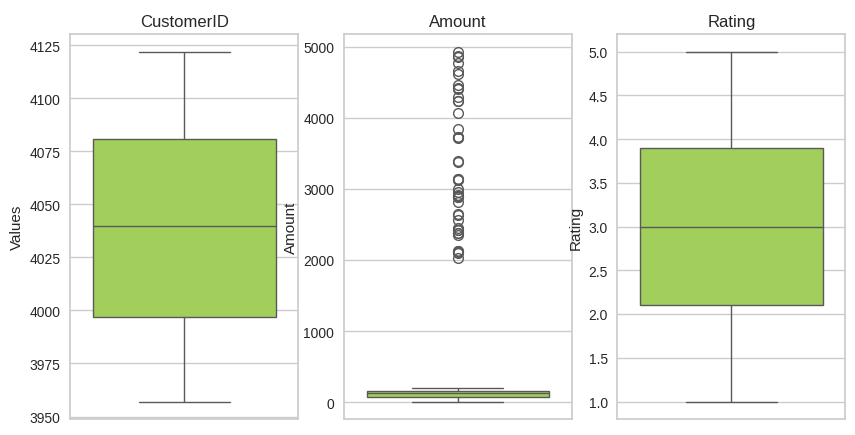

In [10]:
# outliers
def boxplots_custom(dataset, columns_list, rows, cols, suptitle,size=(10,5)):
    fig, axs = plt.subplots(rows, cols,  figsize=size)
    fig.suptitle(suptitle,y=0.93, size=10)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        if i % cols == 0:
            axs[i].set_ylabel('Values')
        sns.boxplot( data=dataset[data], orient='v', ax=axs[i], palette = palette)
        axs[i].set_title(data)

numeric_columns = data.select_dtypes(include=['number']).columns
boxplots_custom(dataset=data, columns_list=numeric_columns, rows=1, cols=3, suptitle=' ')

In [11]:
data = data[data["Amount"] < 200]

In [12]:
data.head()

,CustomerID,Product,Amount,PurchaseDate,Rating,PaymentMethod
43,3992,Backpack,101.000000,2022-12-13,1.3,Credit Card
44,4105,Dress,164.000000,2022-10-20,3.2,Credit Card
45,4119,Boots,21.000000,2023-04-03,3.9,Cash
46,3957,Camisole,147.000000,2022-11-04,4.7,Cash
47,3994,Loafers,156.709818,2023-05-16,3.9,Cash


In [13]:
data_encoder = data.copy()
#Get list of categorical variables
LE=LabelEncoder()
object_cols = data.select_dtypes(include=['object']).columns
for i in object_cols:
    data_encoder[i]=data[[i]].apply(LE.fit_transform)
print('All features are now numerical')
data_encoder.head()

All features are now numerical


,CustomerID,Product,Amount,PurchaseDate,Rating,PaymentMethod
43,3992,0,101.000000,2022-12-13,1.3,1
44,4105,9,164.000000,2022-10-20,3.2,1
45,4119,4,21.000000,2023-04-03,3.9,0
46,3957,6,147.000000,2022-11-04,4.7,0
47,3994,21,156.709818,2023-05-16,3.9,0


In [14]:
data_clustering=data_encoder[["Product","Amount","Rating","PaymentMethod"]]
#Scaling
scaler = StandardScaler()
scaler.fit(data_clustering)
scaled_features = pd.DataFrame(scaler.transform(data_clustering),columns= data_clustering.columns )
print('All features are now scalled')
scaled_features.head()

All features are now scalled


,Product,Amount,Rating,PaymentMethod
0,-1.690639,-0.275377,-1.542270,0.960953
1,-1.069713,0.907033,0.186313,0.960953
2,-1.414672,-1.776851,0.823159,-1.040633
3,-1.276688,0.587970,1.550984,-1.040633
4,-0.241812,0.770208,0.823159,-1.040633


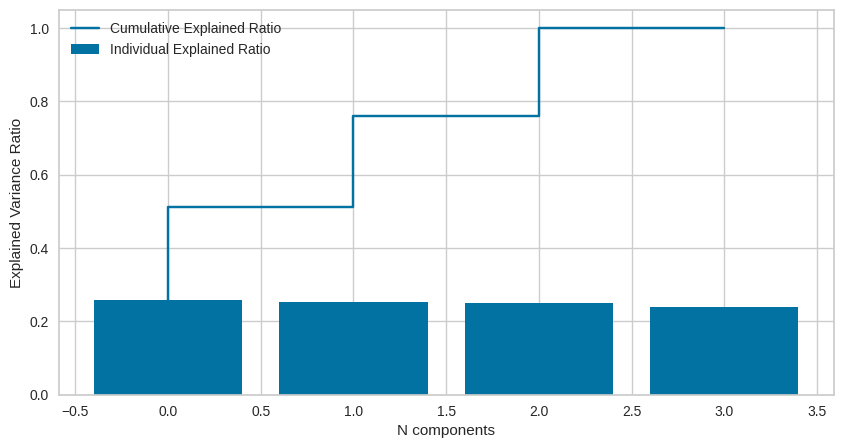

In [15]:
pca = PCA()
pca.fit(scaled_features)
cum_sum_eigenvalues = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10,5))
plt.bar(range(0, len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, label="Individual Explained Ratio")
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, label="Cumulative Explained Ratio")
plt.xlabel("N components")
plt.ylabel("Explained Variance Ratio")
plt.legend(loc="best")
plt.show()

In [16]:
cols = ["PCA1", "PCA2", "PCA3"]
pca = PCA(n_components=len(cols))
pca.fit(scaled_features)
PCA_df = pd.DataFrame(pca.transform(scaled_features), columns=(cols))
PCA_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PCA1,3341.0,-2.658421e-17,1.017638,-2.781141,-0.702348,0.021147,0.752304,2.450609
PCA2,3341.0,4.253473e-18,1.004902,-2.227233,-0.793026,0.026727,0.781485,2.182750
PCA3,3341.0,1.010200e-17,0.999751,-2.538491,-0.743713,0.019539,0.722773,2.627626


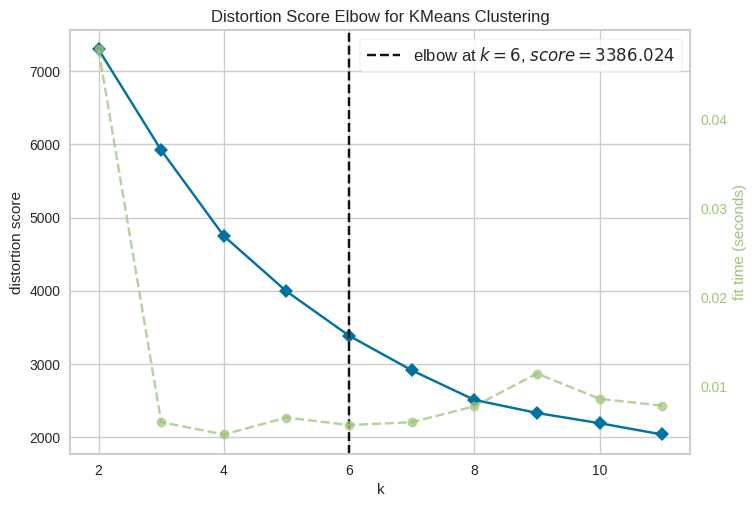

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=11)
visualizer.fit(PCA_df)        # Fit the data to the visualizer
visualizer.show()

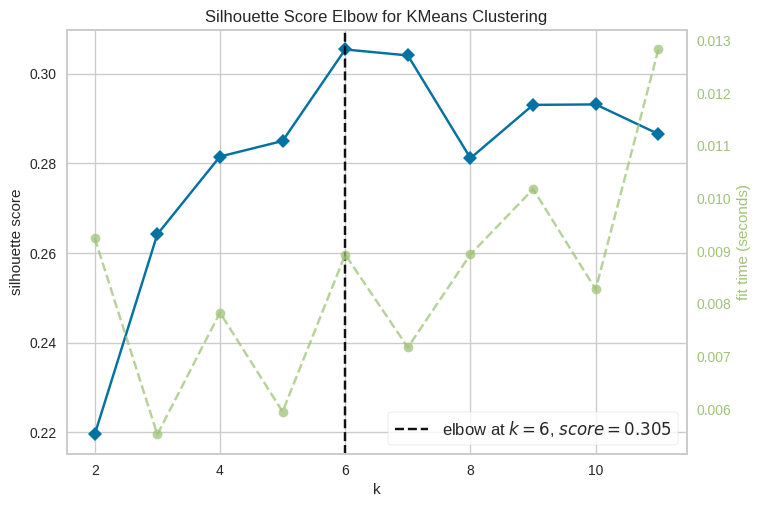

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [18]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=11, metric='silhouette')
visualizer.fit(PCA_df)        # Fit the data to the visualizer
visualizer.show()

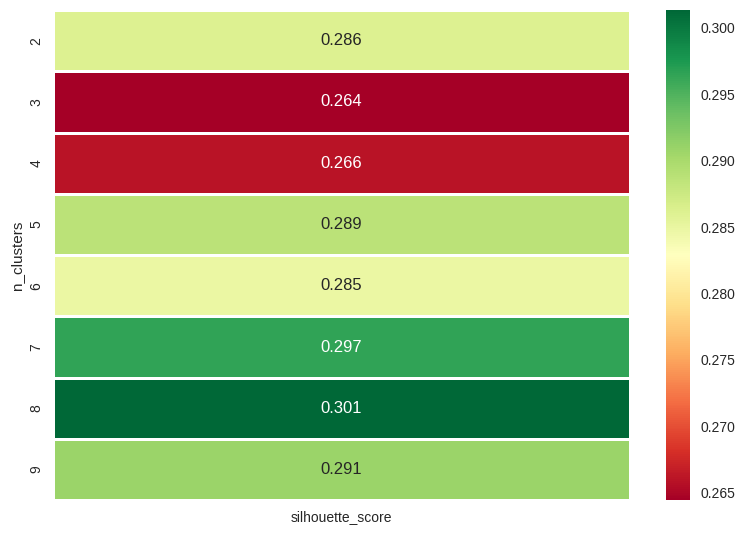

In [19]:
from sklearn.metrics import silhouette_score
def visualize_silhouette_layer(data):
    clusters_range = range(2,10)
    results = []

    for i in clusters_range:
        km = KMeans(n_clusters=i, random_state=42)
        cluster_labels = km.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=1, fmt='.3f', cmap='RdYlGn')
    plt.tight_layout()
    plt.show()

visualize_silhouette_layer(PCA_df)

In [20]:

#Initiating the Agglomerative Clustering model
nb_clusters = visualizer.elbow_value_
AC = AgglomerativeClustering(n_clusters=5)#nb_clusters

# fit model and predict clusters
AC_df = AC.fit_predict(PCA_df)
PCA_df["Clusters"] = AC_df
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= AC_df

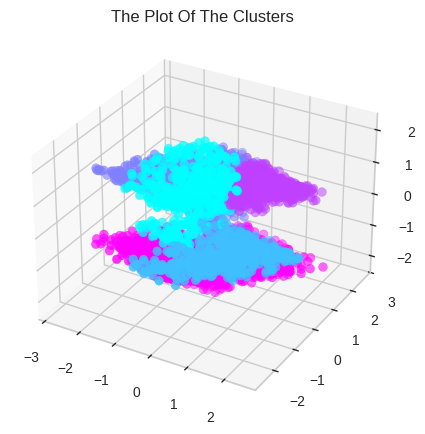

In [21]:
#Plotting the clusters
x =PCA_df["PCA1"]
y =PCA_df["PCA3"]
z =PCA_df["PCA2"]
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_df["Clusters"], marker='o', cmap = 'cool_r' )
ax.set_title("The Plot Of The Clusters")
plt.show()

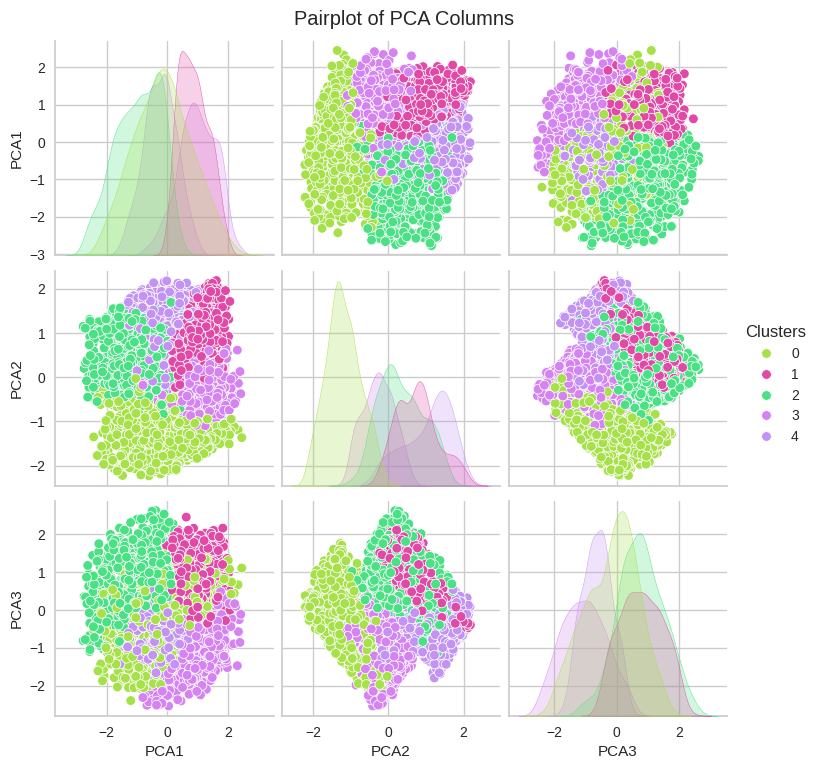

In [22]:
# Create a pairplot for all combinations of PCA columns
sns.pairplot(data=PCA_df, vars=['PCA1', 'PCA2', 'PCA3'], hue='Clusters', palette=palette)
plt.suptitle("Pairplot of PCA Columns", y=1.02)
plt.show()

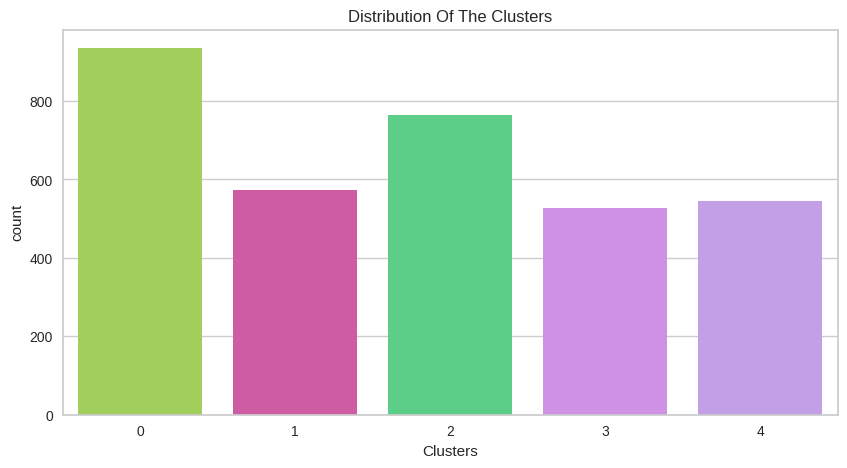

In [23]:
#Plotting countplot of clusters
fig = plt.figure(figsize=(10,5))
pl = sns.countplot(x=data["Clusters"],palette= palette)
pl.set_title("Distribution Of The Clusters")
plt.show()

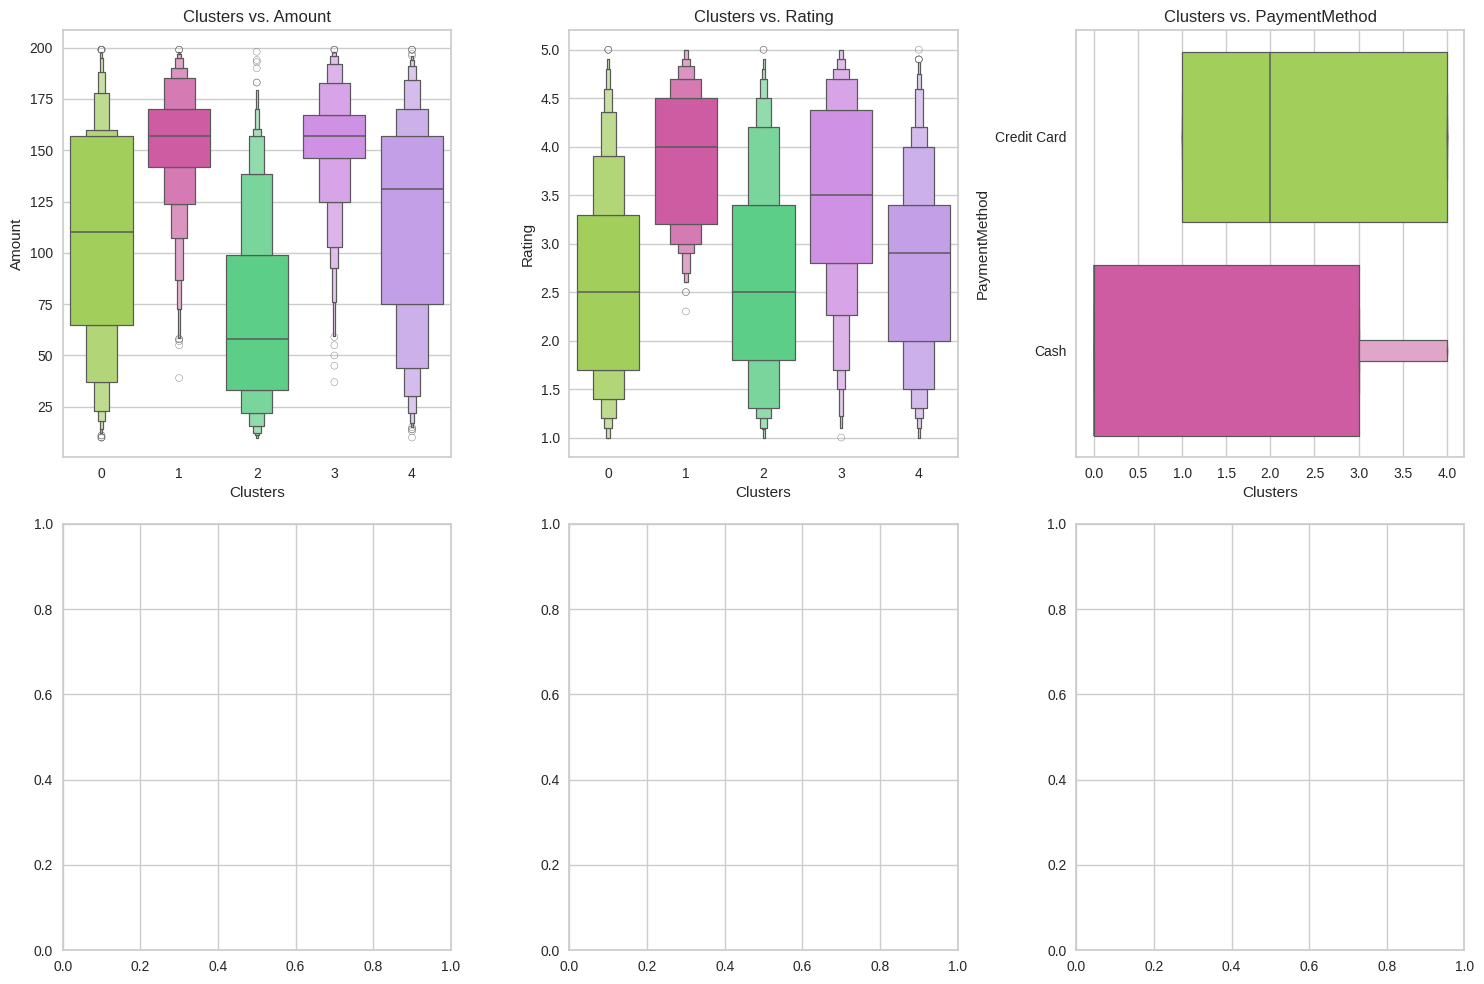

In [24]:

columns=["Amount","Rating","PaymentMethod"]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, column in enumerate(columns):
    row = i // 3
    col = i % 3
    sns.boxenplot(x=data["Clusters"], y=data[column], palette=palette, ax=axes[row, col])
    axes[row, col].set_title(f'Clusters vs. {column}')

plt.tight_layout()
plt.show()

In [25]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

In [26]:
import pandas as pd
from datetime import datetime

# Calculate Recency, Frequency, and Monetary
current_date = max(data['PurchaseDate'])
rfm = data.groupby('CustomerID').agg({
    'PurchaseDate': lambda x: ((current_date - x.max()).days)/7,
    'CustomerID': 'count',
    'Amount': 'sum'
})

rfm['Amount'] = (rfm['Amount'] / 7).astype(int)
# Rename columns to R, F, and M
rfm.rename(columns={
    'PurchaseDate': 'Recency',
    'CustomerID': 'Frequency',
    'Amount': 'Monetary'
}, inplace=True)

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
3957,12.142857,14,231
3958,2.428571,20,257
3959,4.000000,22,359
3960,2.428571,18,272
3961,4.714286,22,370


In [27]:
#RFM SCORES
def get_rfm_scores(data):
    data["R"] = pd.qcut(data["Recency"], 5, labels=[5, 4, 3, 2, 1])
    data["F"] = pd.qcut(data["Frequency"].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
    data["M"] = pd.qcut(data["Monetary"], 5, labels=[1, 2, 3, 4, 5])
    data["RFM_SCORE"] = data["R"].astype(str) + data["F"].astype(str)
    return data

get_rfm_scores(rfm)
rfm.reset_index()
#RFM segment
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex = True)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_SCORE,segment
CustomerID,,,,,,,,
3957,12.142857,14,231,1,1,1,11,hibernating
3958,2.428571,20,257,3,3,1,33,need_attention
3959,4.000000,22,359,2,4,4,24,at_Risk
3960,2.428571,18,272,3,2,2,32,about_to_sleep
3961,4.714286,22,370,1,4,4,14,at_Risk


In [28]:
df = rfm.copy()
x = df.segment.value_counts()
fig = px.treemap(x, path=[x.index], values=x, color=x.index,
    color_discrete_map={x.index[i]: palette[i % len(palette)] for i in range(len(x.index))})
fig.update_layout(title_text='Distribution of the RFM Segments', title_x=0.5,title_font=dict(size=40))
fig.update_traces(textinfo="label+value+percent root")
fig.show()

<p style="background-color:#e6daf9;font-family:newtimeroman;font-size:200%;color:#7541ca;text-align:center;border-radius:70px 10px;padding:7px;border:solid 3px #4e2b87;">To be continued.</p>

<p style="background-color:#e6daf9;font-family:newtimeroman;font-size:170%;color:#7541ca;text-align:center;border-radius:10px 70px;padding:7px;border:solid 3px #4e2b87;">If my notebook has imparted valuable insights to you, your upvote is sincerely appreciated.
</p>